# PIK3CA: Effects of Mutation on RPS6KA4

<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [2]:
import CPTAC

Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# PI3KCA mutation and RPS6KA4 proteome abundance 

<b> Take out the control </b>

In [4]:
proteomics = proteomics[:100]

### Perform a t-test with mutated and non-mutated protein levels

In [5]:
protList = ['RPS6KA4']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest) 
            

Unsignificant result for RPS6KA4: 
Ttest_indResult(statistic=-1.8592107502663087, pvalue=0.06609250432711469)


 ### We can now plot the data 

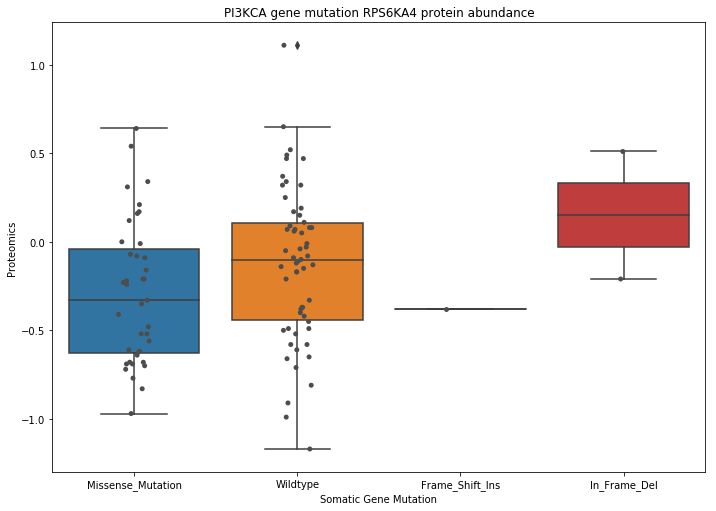

In [7]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='RPS6KA4', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation RPS6KA4 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='RPS6KA4',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and RPS6KA4 phosphoproteome abundance 

In [8]:
sites = phos.columns
p_values = []
site_names = []
protein = 'RPS6KA4'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            site_names.append(site)     
                
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

['RPS6KA4-S682' 'RPS6KA4-S737']
[0.00027672 0.00036802]
{'RPS6KA4-S682': 0.00027672222461751895, 'RPS6KA4-S737': 0.00036802280991522025}


In [9]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

## Plot all of the statistically significant phosphoproteomic measurements

In [10]:
protein = 'RPS6KA4'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
#print(phosdf)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [11]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]
plotdf = None

In [12]:
for site in significant_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)

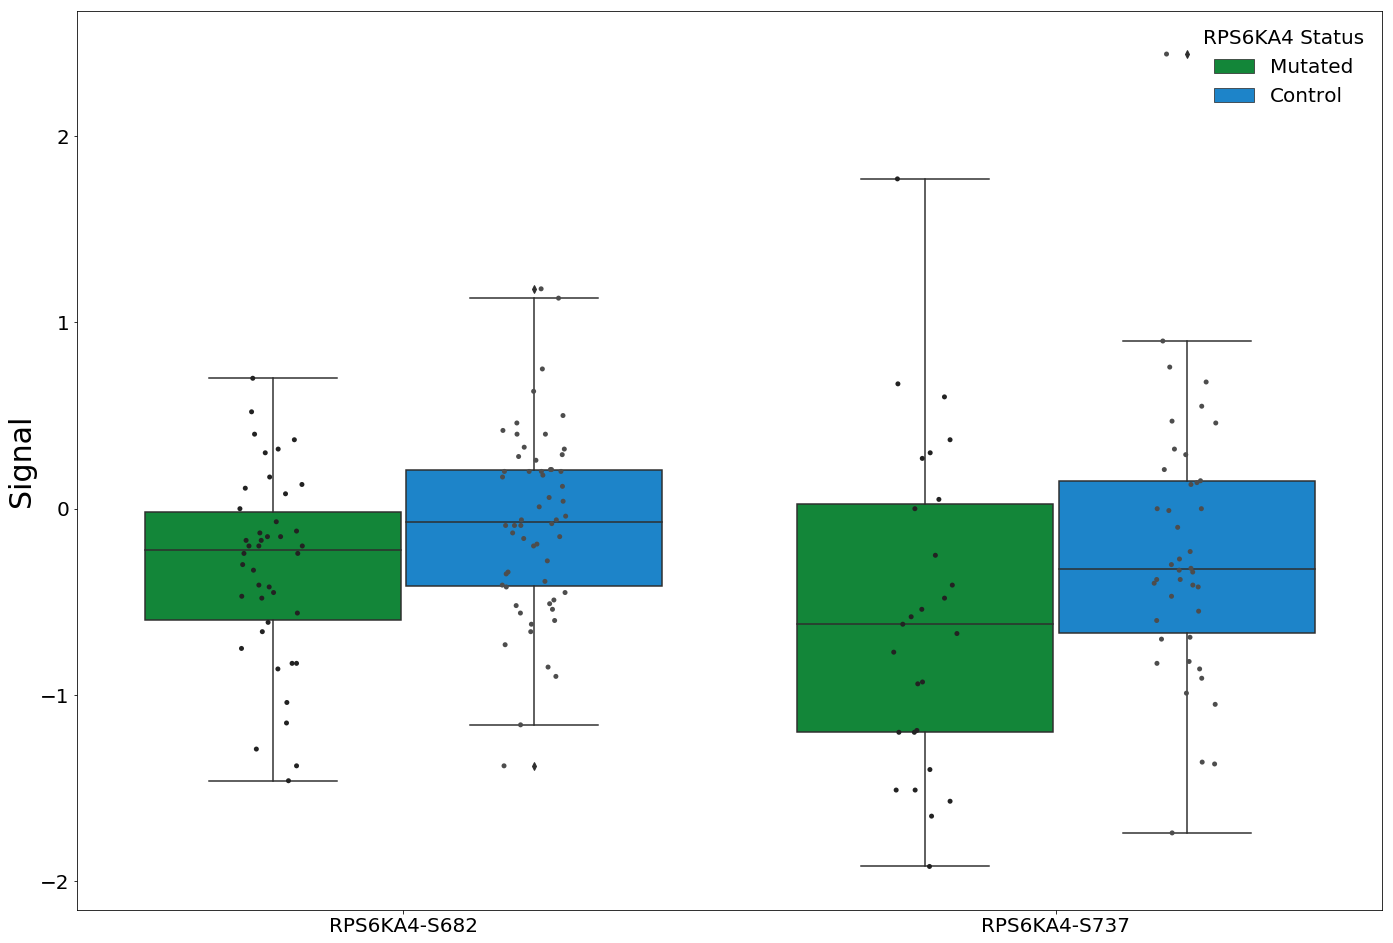

In [13]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='RPS6KA4 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()